<a href="https://colab.research.google.com/github/Suraez/time_series_hws/blob/main/hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, GRU, Bidirectional, Conv1D, MaxPooling1D, Flatten, Input, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from kerastuner.tuners import RandomSearch

<ipython-input-1-5b12bc8f0fe8>:10: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


DATAESET DESCRIPTION

    Huwaei Cloud Dataset
    Type: Multivariate
    Target Feature: requests
    Input Features: Memory, CPU
    Look Back Window Size Considered: 5
    Forecasting Horizon: 1

VISUALIZING THE RAW DATA

In [2]:
def get_fresh_df():
  df = pd.read_csv('preprocessed_dataset.csv', parse_dates=['timestamp'])
  df.set_index('timestamp', inplace=True)
  df = df.ffill()

  return df


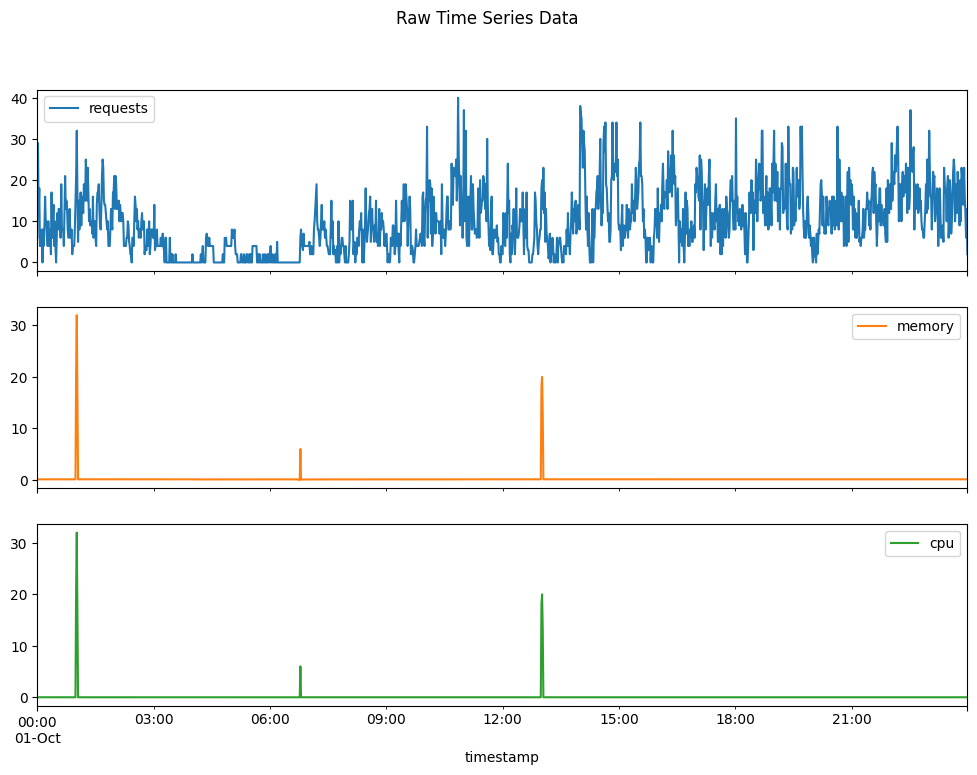

In [3]:
df = get_fresh_df()
df.plot(subplots=True, figsize=(12, 8), title="Raw Time Series Data")
plt.show()


ALL MODELS DEFINITION WITHOUT HYPERPARAMETER CONFIG (hyperparameter tuning done later in this notebook)

In [4]:
def build_ffnn(input_shape):
    return Sequential([
        Input(shape=input_shape),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1)
    ])

def build_rnn(input_shape):
    return Sequential([
        SimpleRNN(50, activation='tanh', input_shape=input_shape),
        Dense(1)
    ])

def build_gru(input_shape):
    return Sequential([
        GRU(50, activation='relu', input_shape=input_shape),
        Dense(1)
    ])

def build_lstm(input_shape):
    return Sequential([
        LSTM(50, activation='relu', input_shape=input_shape),
        Dense(1)
    ])

def build_bilstm(input_shape):
    return Sequential([
        Bidirectional(LSTM(50, activation='relu'), input_shape=input_shape),
        Dense(1)
    ])

def build_cnn(input_shape):
    return Sequential([
        Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(50, activation='relu'),
        Dense(1)
    ])

In [5]:
model_list = {
    "Feedforward NN": build_ffnn,
    "Vanilla RNN": build_rnn,
    "GRU": build_gru,
    "LSTM": build_lstm,
    "BiLSTM": build_bilstm,
    "CNN": build_cnn,
}


Preparing the dataset

In [6]:
def create_sequences(data, target_index, seq_length=5):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, target_index])
    return np.array(X), np.array(y)

Splitting the dataset into train and test

In [7]:
def train_test_split_sequences(X, y, train_ratio=0.8):
    train_size = int(len(X) * train_ratio)
    return X[:train_size], X[train_size:], y[:train_size], y[train_size:]

Fitting a scale on train & then using same scaler on test data

In [8]:
def scale_features(X_train, X_test):
    n_features = X_train.shape[2]
    scaler = MinMaxScaler()
    #first fitting the scaler on train as suggested in last homework
    X_train_scaled = scaler.fit_transform(X_train.reshape(-1, n_features)).reshape(X_train.shape)
    # now apply the same scaler on test
    X_test_scaled = scaler.transform(X_test.reshape(-1, n_features)).reshape(X_test.shape)
    return X_train_scaled, X_test_scaled, scaler

Using a different scaler for target variable

In [9]:
# another scaler for target variable
# first fit on train data
# then apply the scaler on test
def scale_target_independent(y_train, y_test):
    scaler = MinMaxScaler()
    y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_test_scaled = scaler.transform(y_test.reshape(-1, 1)).flatten()
    return y_train_scaled, y_test_scaled, scaler

For comparison, reverting back to original values

In [10]:
# reverting back for comparison
def inverse_scale_target(y_scaled, scaler):
    return scaler.inverse_transform(y_scaled.reshape(-1, 1)).flatten()

Avoids the "divided by zero" error

In [11]:
def safe_mape(y_true, y_pred):
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100


Getting all the metrics

In [12]:
def regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = safe_mape(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return {
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape,
        "R2": r2
    }


In [13]:
def print_metrics(metrics):
  for k, v in metrics.items():
    print(f"  {k}: {v:.4f}")


Preprocessing Steps:
  i.

*   Forward Fill done in get_fresh_df() method
*   Scaling
*   Splitting dataset into train and test


In [14]:
def prepare_Data(df, target_col="requests", sequence_length=5, train_ratio=0.8):
    values = df.values
    target_index = df.columns.get_loc(target_col)
    n_features = values.shape[1]

    # Create sequences
    X, y = create_sequences(values, target_index, sequence_length)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split_sequences(X, y, train_ratio=train_ratio)

    # Scale inputs (features)
    X_train_scaled, X_test_scaled, feature_scaler = scale_features(X_train, X_test)

    # Scale targets separately
    y_train_scaled, y_test_scaled, target_scaler = scale_target_independent(y_train, y_test)

    return {
        "X_train_scaled": X_train_scaled,
        "X_test_scaled": X_test_scaled,
        "y_train_scaled": y_train_scaled,
        "y_test_scaled": y_test_scaled,
        "target_index": target_index,
        "n_features": n_features,
        "sequence_length": sequence_length,
        "feature_scaler": feature_scaler,
        "target_scaler": target_scaler
    }


In [15]:
def run_models_on_df(df, label="Non-Differenced"):
    print(f"\n Running models on: {label} data")

    data = prepare_Data(df)

    X_train_scaled = data["X_train_scaled"]
    X_test_scaled = data["X_test_scaled"]
    y_train_scaled = data["y_train_scaled"]
    y_test_scaled = data["y_test_scaled"]
    target_index = data["target_index"]
    n_features = data["n_features"]
    sequence_length = data["sequence_length"]
    target_scaler = data["target_scaler"]


    results = {}

    for name, builder in model_list.items():
        print(f"\n {name} ({label})")
        model = builder(input_shape=(sequence_length, n_features))
        model.compile(optimizer=Adam(0.001), loss='mse')
        model.fit(X_train_scaled, y_train_scaled, epochs=50, verbose=0)

        # Predict
        y_pred_scaled = model.predict(X_test_scaled).flatten()

        # Inverse scale
        y_pred = inverse_scale_target(y_pred_scaled, target_scaler)
        y_true = inverse_scale_target(y_test_scaled, target_scaler)

        # Evaluation Metrics
        metrics = regression_metrics(y_true, y_pred)
        print(f"{name} Performance ({label}):")
        print_metrics(metrics)

        results[name] = {
            "y_true": y_true,
            "y_pred": y_pred,
            "metrics": metrics
        }


    return results

Running all models on Non-differencing data

In [16]:
results_non_diff = run_models_on_df(df.copy(), label="Non-Differenced")


 Running models on: Non-Differenced data

 Feedforward NN (Non-Differenced)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Feedforward NN Performance (Non-Differenced):
  MAE: 4.6784
  RMSE: 6.0195
  MAPE: 43.5329
  R2: 0.2163

 Vanilla RNN (Non-Differenced)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Vanilla RNN Performance (Non-Differenced):
  MAE: 4.7396
  RMSE: 6.0912
  MAPE: 45.7493
  R2: 0.1975

 GRU (Non-Differenced)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
GRU Performance (Non-Differenced):
  MAE: 4.7726
  RMSE: 6.1338
  MAPE: 42.5752
  R2: 0.1863

 LSTM (Non-Differenced)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
LSTM Performance (Non-Differenced):
  MAE: 4.7451
  RMSE: 6.0786
  MAPE: 44.0185
  R2: 0.2009

 BiLSTM (Non-Differenced)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
BiLSTM Performance (Non-Differenced):
  MAE: 4.7982
  RMSE: 6.1756
  MAPE: 41.9544
  R2: 0.1752

 CNN (Non-Differenced)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
CNN Performance (Non-Differenced):
  MAE: 4.8538
  RMSE: 6.2239
  MAPE: 45.1677
  R2: 0.1622


Running all models on Differencing data

In [17]:
results_diff = run_models_on_df(df.diff().dropna(), label="Differenced")


 Running models on: Differenced data

 Feedforward NN (Differenced)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Feedforward NN Performance (Differenced):
  MAE: 5.0029
  RMSE: 6.5166
  MAPE: 109.7303
  R2: 0.2072

 Vanilla RNN (Differenced)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Vanilla RNN Performance (Differenced):
  MAE: 4.8375
  RMSE: 6.2948
  MAPE: 100.7982
  R2: 0.2602

 GRU (Differenced)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
GRU Performance (Differenced):
  MAE: 4.8860
  RMSE: 6.3118
  MAPE: 104.8823
  R2: 0.2562

 LSTM (Differenced)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
LSTM Performance (Differenced):
  MAE: 5.2649
  RMSE: 6.8627
  MAPE: 112.8130
  R2: 0.1207

 BiLSTM (Differenced)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
BiLSTM Performance (Differenced):
  MAE: 4.8214
  RMSE: 6.2357
  MAPE: 103.8344
  R2: 0.2741

 CNN (Differenced)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
CNN Performance (Differenced):
  MAE: 4.8827
  RMSE: 6.2903
  MAPE: 104.6973
  R2: 0.2613


In [31]:
def plot_model_predictions_grid(results, title="Forecast Comparison"):
    model_names = list(results.keys())
    fig, axes = plt.subplots(2, 3, figsize=(18, 8))
    axes = axes.flatten()

    for i, name in enumerate(model_names):
        model_data = results[name]
        y_true = model_data["y_true"]
        y_pred = model_data["y_pred"]
        metrics = model_data["metrics"]

        subtitle = f"{name}\nMAE: {metrics['MAE']:.2f}  RMSE: {metrics['RMSE']:.2f}  MAPE: {metrics['MAPE']:.2f} R²: {metrics['R2']:.2f}"

        axes[i].plot(y_true, label="Actual", linewidth=2)
        axes[i].plot(y_pred, label="Predicted", linestyle="--")
        axes[i].set_title(subtitle, fontsize=10)
        axes[i].legend()
        axes[i].grid(True)

    for j in range(len(model_names), len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


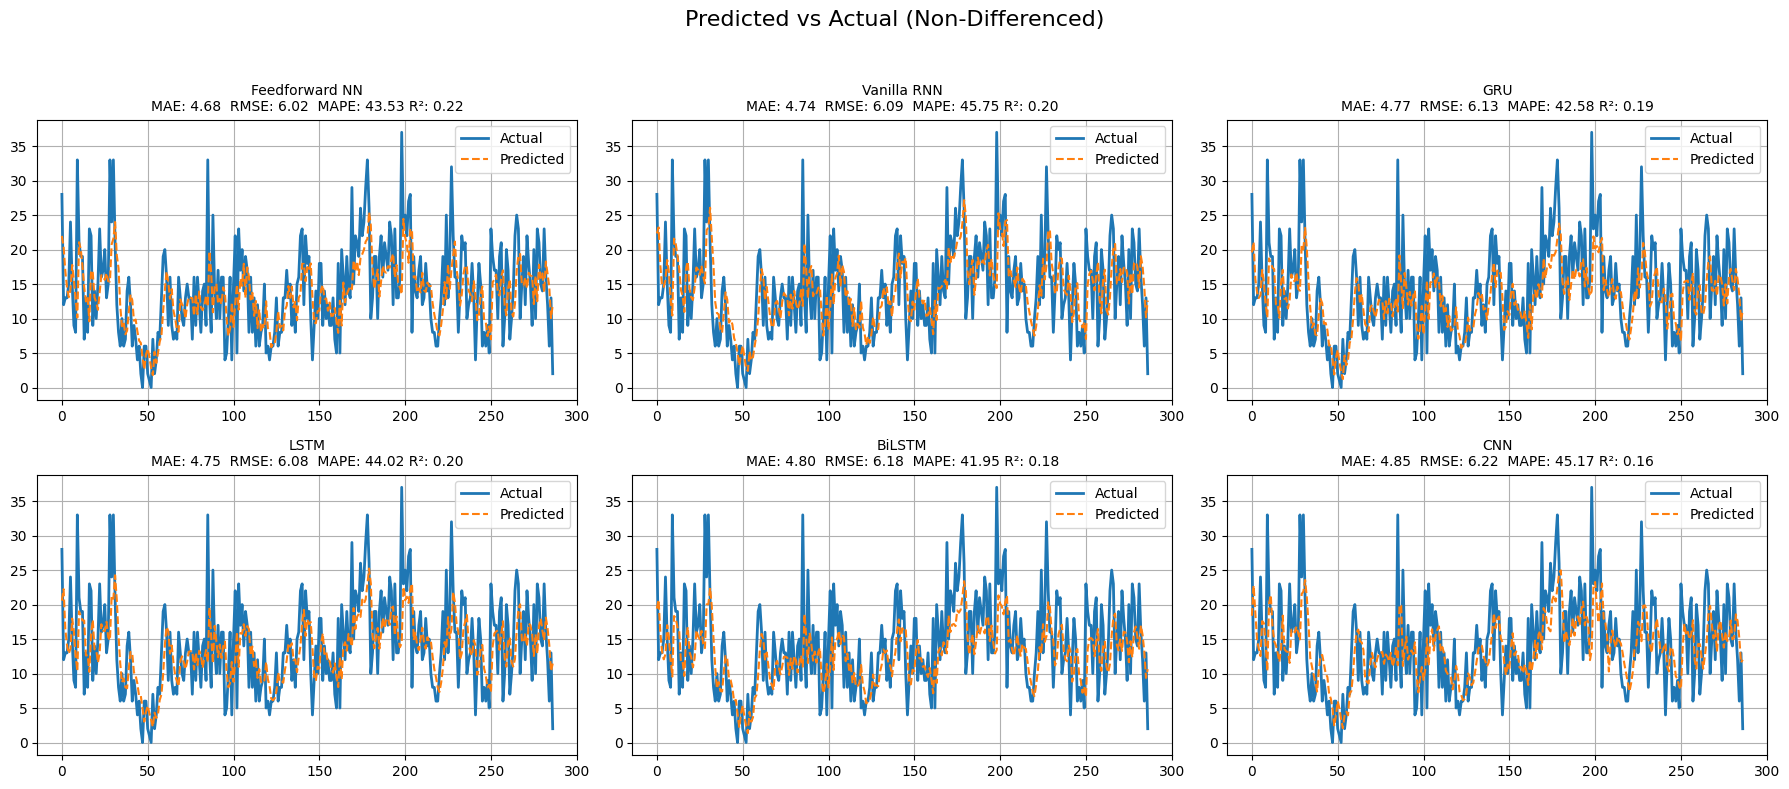

In [32]:
plot_model_predictions_grid(results_non_diff, title="Predicted vs Actual (Non-Differenced)")


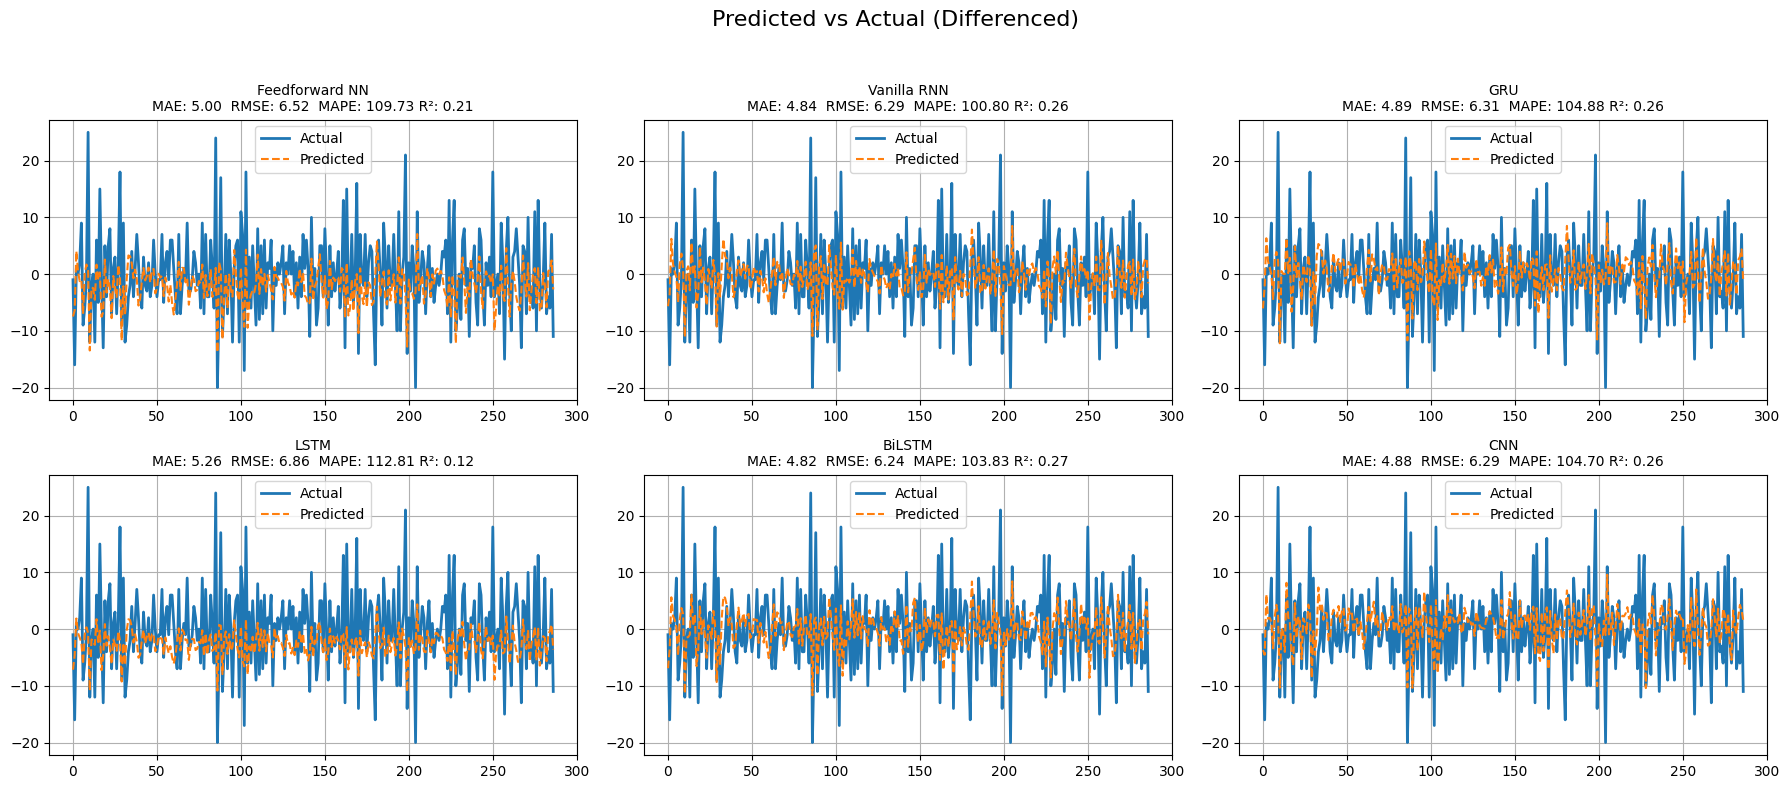

In [33]:
plot_model_predictions_grid(results_diff, title="Predicted vs Actual (Differenced)")

### Hyperparameter Tunning

In [21]:
df = pd.read_csv('preprocessed_dataset.csv', parse_dates=['timestamp'])
df.set_index('timestamp', inplace=True)
df = df.ffill()

data = prepare_Data(df)

Common Function for evaluating all models after hyperparameter tunning

In [22]:
df = get_fresh_df()

data = prepare_Data(df)

def tune_model_and_evaluate(model_name, dir_name, project_name):
    tuner = RandomSearch(
      model_name,
      objective='val_loss',
      max_trials=5,
      executions_per_trial=1,
      directory=dir_name,
      project_name=project_name
      )

    tuner.search_space_summary()

    # Step 3: Run the tuner
    tuner.search(data["X_train_scaled"], data["y_train_scaled"],  epochs=50,  batch_size=32,  validation_split=0.2, verbose=1)

    best_model = tuner.get_best_models(num_models=1)[0]

    # Predict
    y_pred_scaled = best_model.predict(data["X_test_scaled"]).flatten()
    y_pred = inverse_scale_target(y_pred_scaled,  data["target_scaler"] )
    y_true = inverse_scale_target(data["y_test_scaled"], data["target_scaler"])

    # Evaluate
    metrics = regression_metrics(y_true, y_pred)
    print_metrics(metrics)

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    for hp_name in best_hps.values:
        print(f"{hp_name}: {best_hps.get(hp_name)}")


FNN Feed Forward Neural Network HyperParameter Tuning

In [23]:
df = get_fresh_df()

data = prepare_Data(df)

def build_fnn_model(hp):
    model = Sequential()
    model.add(Input(shape=(data["sequence_length"], data['n_features'])))
    model.add(Flatten())

    # Tune number of layers
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Dense(
            units=hp.Choice(f'units_{i}', [32, 64, 128]),
            activation=hp.Choice('activation', ['relu', 'tanh'])
        ))

    model.add(Dense(1))

    # Tune learning rate
    lr = hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    return model

tune_model_and_evaluate(build_fnn_model, 'fnn_tuning', 'forecasting_fnn')

Trial 5 Complete [00h 00m 15s]
val_loss: 0.022995630279183388

Best val_loss So Far: 0.02211652509868145
Total elapsed time: 00h 01m 19s
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


  MAE: 4.6922
  RMSE: 6.0294
  MAPE: 44.9091
  R2: 0.2138
num_layers: 3
units_0: 64
activation: relu
learning_rate: 0.0005
units_1: 32
units_2: 32


Vanilla RNN Hyperparameter Tunning

In [24]:
df = get_fresh_df()

data = prepare_Data(df)

# Step 1: Define RNN model for tuner
def build_rnn_model(hp):
    model = Sequential()
    model.add(Input(shape=(data["sequence_length"], data["n_features"])))

    for i in range(hp.Int("num_layers", 1, 2)):
        return_seq = (i < hp.get("num_layers") - 1)
        model.add(SimpleRNN(
            units=hp.Choice(f"units_{i}", [32, 64, 128]),
            activation=hp.Choice("activation", ["tanh", "relu"]),
            return_sequences=return_seq
        ))
        model.add(Dropout(hp.Float("dropout_rate", 0.0, 0.5, step=0.1)))

    model.add(Dense(1))

    lr = hp.Choice("learning_rate", [0.001, 0.0005, 0.0001])
    model.compile(optimizer=Adam(learning_rate=lr), loss="mse")
    return model


tune_model_and_evaluate(build_rnn_model, 'rnn_tuning', 'forecasting_rnn')

Trial 5 Complete [00h 00m 17s]
val_loss: 0.022651128470897675

Best val_loss So Far: 0.021877214312553406
Total elapsed time: 00h 01m 38s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
  MAE: 4.7030
  RMSE: 6.0184
  MAPE: 45.3068
  R2: 0.2166
num_layers: 2
units_0: 128
activation: relu
dropout_rate: 0.0
learning_rate: 0.0001
units_1: 32


GRU Hyperparameter Tunning



In [25]:
df = get_fresh_df()

data = prepare_Data(df)

def build_gru_model(hp):
    model = Sequential()
    model.add(Input(shape=(data["sequence_length"], data["n_features"])))

    for i in range(hp.Int("num_layers", 1, 2)):
        return_seq = (i < hp.get("num_layers") - 1)
        model.add(GRU(
            units=hp.Choice(f"units_{i}", [32, 64, 128]),
            activation=hp.Choice("activation", ["tanh", "relu"]),
            return_sequences=return_seq
        ))
        model.add(Dropout(hp.Float("dropout_rate", 0.0, 0.5, step=0.1)))

    model.add(Dense(1))

    lr = hp.Choice("learning_rate", [0.001, 0.0005, 0.0001])
    model.compile(optimizer=Adam(learning_rate=lr), loss="mse")
    return model


tune_model_and_evaluate(build_gru_model, 'gru_tuning', 'forecasting_gru')

Trial 5 Complete [00h 00m 19s]
val_loss: 0.02496809884905815

Best val_loss So Far: 0.022501856088638306
Total elapsed time: 00h 02m 04s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
  MAE: 4.7335
  RMSE: 6.0721
  MAPE: 45.0820
  R2: 0.2026
num_layers: 2
units_0: 64
activation: tanh
dropout_rate: 0.0
learning_rate: 0.001
units_1: 32


LSTM Hyperparameter Tunning


In [26]:
df = get_fresh_df()

data = prepare_Data(df)
def build_lstm_model(hp):
    model = Sequential()
    model.add(Input(shape=(data["sequence_length"], data["n_features"])))

    for i in range(hp.Int("num_layers", 1, 2)):
        return_seq = (i < hp.get("num_layers") - 1)
        model.add(LSTM(
            units=hp.Choice(f"units_{i}", [32, 64, 128]),
            activation=hp.Choice("activation", ["tanh", "relu"]),
            return_sequences=return_seq
        ))
        model.add(Dropout(hp.Float("dropout_rate", 0.0, 0.5, step=0.1)))

    model.add(Dense(1))
    lr = hp.Choice("learning_rate", [0.001, 0.0005, 0.0001])
    model.compile(optimizer=Adam(learning_rate=lr), loss="mse")
    return model

tune_model_and_evaluate(build_lstm_model, 'lstm_tunning', 'forecasting_lstm')


Trial 5 Complete [00h 00m 42s]
val_loss: 0.022302648052573204

Best val_loss So Far: 0.022302648052573204
Total elapsed time: 00h 02m 41s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
  MAE: 4.7205
  RMSE: 6.0448
  MAPE: 45.4639
  R2: 0.2097
num_layers: 2
units_0: 64
activation: tanh
dropout_rate: 0.1
learning_rate: 0.001
units_1: 128


BiLSTM Hyperparameter Tuning

In [27]:
df = get_fresh_df()

data = prepare_Data(df)
def build_bilstm_model(hp):
    model = Sequential()
    model.add(Input(shape=(data["sequence_length"], data["n_features"])))

    for i in range(hp.Int("num_layers", 1, 2)):
        return_seq = (i < hp.get("num_layers") - 1)
        model.add(Bidirectional(LSTM(
            units=hp.Choice(f"units_{i}", [32, 64, 128]),
            activation=hp.Choice("activation", ["tanh", "relu"]),
            return_sequences=return_seq
        )))
        model.add(Dropout(hp.Float("dropout_rate", 0.0, 0.5, step=0.1)))

    model.add(Dense(1))
    lr = hp.Choice("learning_rate", [0.001, 0.0005, 0.0001])
    model.compile(optimizer=Adam(learning_rate=lr), loss="mse")
    return model

tune_model_and_evaluate(build_bilstm_model, 'biLstm_tuning', 'forecasting_biLstm')


Trial 5 Complete [00h 00m 38s]
val_loss: 0.022375114262104034

Best val_loss So Far: 0.02201140858232975
Total elapsed time: 00h 02m 41s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
  MAE: 4.7417
  RMSE: 6.0224
  MAPE: 45.8129
  R2: 0.2156
num_layers: 1
units_0: 32
activation: relu
dropout_rate: 0.2
learning_rate: 0.001


CNN Hyperparameter Tuning

In [28]:
df = get_fresh_df()

data = prepare_Data(df)
def build_cnn_model(hp):
    model = Sequential()
    model.add(Input(shape=(data["sequence_length"], data["n_features"])))

    model.add(Conv1D(
        filters=hp.Choice("filters", [32, 64, 128]),
        kernel_size=hp.Choice("kernel_size", [2, 3, 5]),
        activation=hp.Choice("activation", ["relu", "tanh"]),
        padding="same"
    ))

    model.add(MaxPooling1D(pool_size=hp.Choice("pool_size", [2, 3])))
    model.add(Flatten())
    model.add(Dense(hp.Choice("dense_units", [32, 64, 128]), activation="relu"))
    model.add(Dropout(hp.Float("dropout_rate", 0.0, 0.5, step=0.1)))
    model.add(Dense(1))

    lr = hp.Choice("learning_rate", [0.001, 0.0005, 0.0001])
    model.compile(optimizer=Adam(learning_rate=lr), loss="mse")
    return model

tune_model_and_evaluate(build_cnn_model, 'cnn_tuning', 'forecasting_cnn')


Trial 5 Complete [00h 00m 16s]
val_loss: 0.022161858156323433

Best val_loss So Far: 0.022161858156323433
Total elapsed time: 00h 01m 21s
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
  MAE: 4.8200
  RMSE: 6.1708
  MAPE: 46.0424
  R2: 0.1764
filters: 32
kernel_size: 2
activation: relu
pool_size: 2
dense_units: 32
dropout_rate: 0.0
learning_rate: 0.0005


####Augmented Dickey-Fuller (ADF) Test

In [34]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series, autolag='AIC')

    labels = ['ADF Statistic', 'p-value', '# Lags Used', 'Number of Observations Used']
    for value, label in zip(result[:4], labels):
        print(f'{label}: {value}')

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis (unit root), data is **stationary**.")
    else:
        print("Weak evidence against the null hypothesis, data is **non-stationary**.")

    print('-' * 60)


In [35]:
adf_test(df['requests'])

Augmented Dickey-Fuller Test: 
ADF Statistic: -3.5635634074044056
p-value: 0.006497064521117549
# Lags Used: 24
Number of Observations Used: 1415
✅ Strong evidence against the null hypothesis (unit root), data is **stationary**.
------------------------------------------------------------


CONCLUSION: SINCE THE DATASET IS ALREADY STATIONARY, DIFFERENCING HAD LITTLE TO NO IMPACT IN PERFORMANCE IMPROVEMENT <br>

STRENGTH OF DATASET:

*   STATIONARY

WEAKNESS OF DATASET:

*  IRREGULAR SPIKES BECAUSE OF THE BURSTY NATURE OF CLOUD COMPUTING

THANK YOU!